In [ ]:
# default_exp stats

# Stats
This notebook contains some helpful statistics fucntions

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython
import seaborn as sns
from matplotlib import pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font_scale = 1.3, rc=custom_params)
from trr265.gbe.wm.data_provider import WMDataProvider
import trr265.gbe.wm.scoring as wm_scoring 
import pandas as pd

In [ ]:
#export
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML, Image
import biuR.wrapper

## Loading the data
In this notebook, all tests and examples are run on the initial baseline dataset.

In [ ]:
# Getting raw data
dp = WMDataProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')
df = dp.get_wm_data()
# Adding data from redcap
df = df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
# Filtering out replication and ema data
df = df.query("is_initial and is_baseline")
# Filtering participants with old app
df = dp.filter_old_app_sessions(df)
df = dp.filter_level_two_failures(df)

8 participants used an old version of the task in some of their sessions.  13 sessions (2.48%) were removed from the dataset.
6 sessions (1.17%) were removed because participants failed a level two trial.


## Test-retest reliability

In [ ]:
#export
def icc_description_dict(iccs):
    """A helper function for formatting icc output.
    """
    format_icc = lambda x: ("%.2f"%x)[1:]
    iccs[0]['description'] = iccs[0]['ICC'].apply(format_icc) + ' (' + iccs[0]['lower bound'].apply(format_icc) + ', ' + iccs[0]['upper bound'].apply(format_icc) + ')'
    return {k:v for k,v in zip(iccs[0].type,iccs[0]['description'])}

def describe_iccs(iccs, description = "", silent = False):
    """A helper function for formatting icc output.
    """
    description_dict = icc_description_dict(iccs)
    description_dict['description'] = description
    if not silent:
        display(HTML("The ICC(1) for %(description)s was %(ICC1)s.  The ICC(1,k) for %(description)s was %(ICC1k)s."%description_dict))
        display(iccs[0].round(3))
        display(iccs[1].round(3))
    return description_dict

def retest_plot(df, add_jitter):
    #fig, axs = plt.subplots(1,3, figsize = (16,4))
    fig = plt.figure(figsize = (10,8))
    gs = fig.add_gridspec(3,2)
    axs = []
    axs.append(fig.add_subplot(gs[0, 0]))
    axs.append(fig.add_subplot(gs[0, 1]))
    axs.append(fig.add_subplot(gs[1:, :]))
    for i in range(2):
        df.iloc[:,i].hist(ax = axs[i])
        axs[i].title.set_text(df.columns[i])
        axs[i].grid(False)
    if add_jitter:
        df[str(df.columns[0])+'_j'] = jitter(df.iloc[:,0])
        df[str(df.columns[1])+'_j'] = jitter(df.iloc[:,1])
        ax = df.plot.scatter(x=str(df.columns[0])+'_j',y=str(df.columns[1])+'_j', ax = axs[2], alpha = .8)
        ax.grid(False)
    else:
        ax = df.plot.scatter(x=df.columns[0],y=df.columns[1], ax = axs[2])
        ax.grid(False)
    sns.despine()
    return fig

def jitter(arr):
    return arr + np.random.randn(len(arr)) * arr.std()/10

def analyze_reliability(df, dependent, add_jitter = False, title = '', silent = False):
    df['_session'] = df.session_number.apply(lambda x: "Session %d"%x)
    ssrt_reg = df.set_index(['participant','_session']).unstack()[dependent].dropna()
    iccs = get_psych_iccs(ssrt_reg)
    describe_iccs(iccs,dependent, silent = silent)
    if not silent:
        fig = retest_plot(ssrt_reg, add_jitter)
        title = title if len(title) else "Test-retest reliability: %s"%dependent
        fig.suptitle(title);
        plt.show()
        return {'fig':fig, 'iccs':iccs}
    else:
        return {'fig':None, 'iccs':iccs}


def get_psych_iccs(df):
    """This function calculates ICCs using the psych package.
    """
    R = biuR.wrapper.R()
    R("""
    require(psych)
    options(warn=-1)
    result = psych::ICC(df)
    # Adding the quotes seems to be import because of glitch that leaks python globals into r
    iccs = result$"results"# -o iccs
    lmers = result$"lme"# -o lmers
    """, push = dict(df=df))
    iccs = R("""iccs""")
    lmers = R("""lmers""")

    return iccs,lmers

def get_model_calculated_icc(m):
    R = biuR.wrapper.R()
    p = R("""
    require(insight)
    var_sess <- get_variance_intercept(m)[1]
    var_pp <- get_variance_intercept(m)[2]
    icc <- var_pp / (var_pp+(var_sess))
    """,push=dict(m=m))

    icc = R("""icc""")
    var_sess = R("""var_sess""")
    var_pp = R("""var_pp""")
    variances = pd.DataFrame({"type":["Participant","Session","Residual"],"variance":[var_pp[0],0,var_sess[0]]})
    variances["Percent"] = variances.variance/variances.variance.sum()
    variances = {'iccs':[None, variances]}
    return {'icc':icc[0],'variances':variances}

R[write to console]: Lade nötiges Paket: psych

R[write to console]: boundary (singular) fit: see ?isSingular



,type,ICC,F,df1,df2,p,lower bound,upper bound,description
Single_raters_absolute,ICC1,0.281,1.783,232.0,233.0,0.0,0.179,0.378,".28 (.18, .38)"
Single_random_raters,ICC2,0.281,1.783,232.0,232.0,0.0,0.179,0.378,".28 (.18, .38)"
Single_fixed_raters,ICC3,0.281,1.783,232.0,232.0,0.0,0.179,0.378,".28 (.18, .38)"
Average_raters_absolute,ICC1k,0.439,1.783,232.0,233.0,0.0,0.304,0.548,".44 (.30, .55)"
Average_random_raters,ICC2k,0.439,1.783,232.0,232.0,0.0,0.304,0.548,".44 (.30, .55)"
Average_fixed_raters,ICC3k,0.439,1.783,232.0,232.0,0.0,0.304,0.548,".44 (.30, .55)"


,variance,Percent
ID,0.308,0.281
Items,0.000,0.000
Residual,0.788,0.719
Total,1.096,1.000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


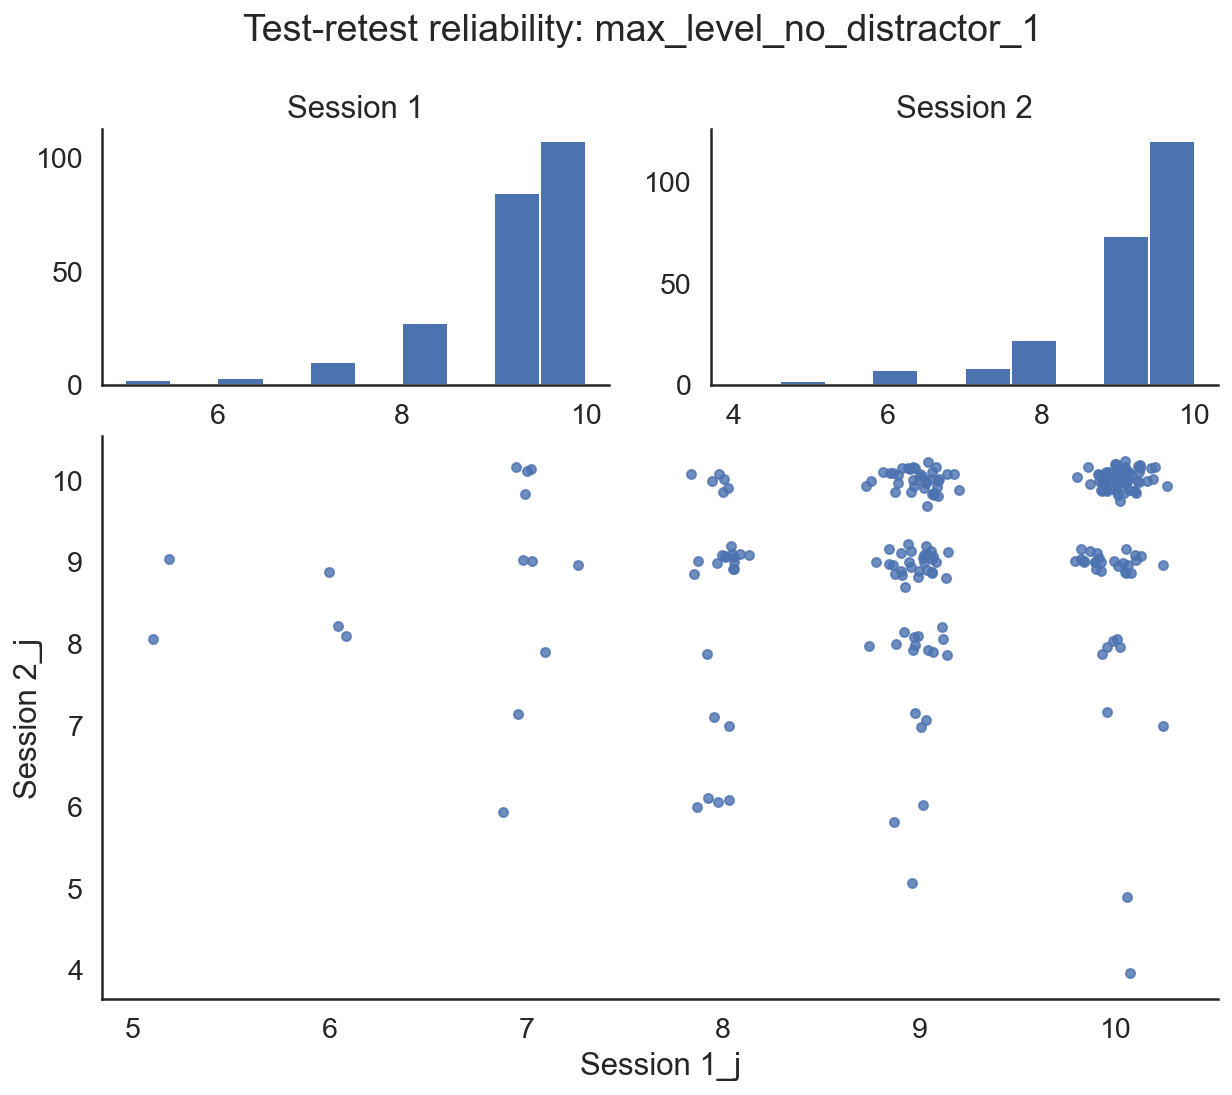

{'fig': <Figure size 720x576 with 3 Axes>,
 'iccs': (                          type       ICC         F    df1    df2         p  \
  Single_raters_absolute    ICC1  0.281285  1.782745  232.0  233.0  0.000006   
  Single_random_raters      ICC2  0.281285  1.782745  232.0  232.0  0.000006   
  Single_fixed_raters       ICC3  0.281285  1.782745  232.0  232.0  0.000006   
  Average_raters_absolute  ICC1k  0.439067  1.782745  232.0  233.0  0.000006   
  Average_random_raters    ICC2k  0.439067  1.782745  232.0  232.0  0.000006   
  Average_fixed_raters     ICC3k  0.439067  1.782745  232.0  232.0  0.000006   
  
                           lower bound  upper bound     description  
  Single_raters_absolute      0.179046     0.377539  .28 (.18, .38)  
  Single_random_raters        0.179006     0.377567  .28 (.18, .38)  
  Single_fixed_raters         0.178919     0.377627  .28 (.18, .38)  
  Average_raters_absolute     0.303713     0.548136  .44 (.30, .55)  
  Average_random_raters       0.3036

In [ ]:
_df = wm_scoring.get_max_levels(df)#['max_level_no_distractor_1']
_df = _df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline']), left_on = 'gbe_index', right_index = True, how = 'left')
analyze_reliability(_df, dependent = 'max_level_no_distractor_1', add_jitter = True)

### Variance proportions

In [ ]:
#export
def var_comp_plot(results):
    perc_variance = []
    for r in results.items():
        _df = r[1]['iccs'][1].T
        _df.columns = ['Participant','Session','Residual','Total']
        perc_variance.append(_df[['Participant','Session','Residual']].loc['Percent'])
    df = pd.DataFrame(perc_variance)
    df.index = results.keys()
    ax = df.plot(kind = 'bar', stacked = True)
    ax.grid(False)
    sns.despine()
    ax.legend(bbox_to_anchor=(1.12, 1.05))
    plt.xticks(rotation=0)
    return ax

### Time effects

In [ ]:
#export
def get_icc_and_variance(_df,
            dependent,
           icc_type = 'ICC2', scaling = 'Percent'):
    '''Helper function that gets ICCs and variances'''
    outcomes = analyze_reliability(_df, dependent = dependent, silent = True)['iccs']
    icc = outcomes[0].query('type=="%s"'%icc_type)['ICC'].iloc[0]
    variances = outcomes[1].T
    variances.columns = ['Participant','Session','Residual','Total']
    variances = variances.loc[scaling]
    return icc,variances.loc['Participant'],variances.loc['Session'],variances.loc['Residual']

def get_scores(dp, data_function, scoring_function, filters = []):
    # Getting the data
    _df = data_function()
    _df = _df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline','time_since_last_gbe']), left_on = 'gbe_index', right_index = True, how = 'left')
    # Filtering
    _df = _df[_df.is_initial==True]
    for filt in filters:
        _df = filt(_df)
    # Scoring
    res = scoring_function(_df)
    if len(res) == 2:
        _df, ms = res
    else:
        _df = res

    _df = _df.merge(dp.get_gbe_data(columns = ['participant','session_number','is_initial','is_baseline','time_since_last_gbe']), left_on = 'gbe_index', right_index = True, how = 'left')
    return _df

def get_time_effect(_df, sessions, dependent, scaling):
    time_data = []
    # Checking which participants have all sessions
    pps = _df.query('session_number<%d'%(sessions+1)).groupby('participant')[_df.columns[0]].agg(lambda x: len(x.dropna()))==sessions
    pps = pps[pps].index
    print("N = %d"%(len(pps)))

    for i in range(sessions-1):
        session_filter = "(session_number==1) or (session_number==%d)"%(i+2)
        __df = _df.query(session_filter)
        __df = __df[__df.participant.isin(pps)]
        d = {}
        d['icc'],d['participant'],d['session'],d['residual'] = get_icc_and_variance(__df, dependent, scaling = scaling)
        time_data.append(d)
    df = pd.DataFrame(time_data, index = pd.Series(range(sessions-1)))
    return df


def plot_time_effect(_df, sessions, dependent, legend = False, scaling = 'Percent', change = False):
    df = get_time_effect(_df, sessions, dependent, scaling)
    if change:
        df[['participant','session','residual']] = (df[['participant','session','residual']]/df[['participant','session','residual']].iloc[0])*100
        ax = df[['icc']].plot(legend = legend, color = 'black', linestyle='--')
        ax.set_ylabel('icc')
        ax2 = ax.twinx()
        ax = df[['participant','session','residual']].plot(legend = legend, ax = ax2)
        if legend:
            ax.figure.legend(bbox_to_anchor=[1.4, 1])
        sns.despine(right=False)
        ax2.set_ylabel('% of initial')
    else:
        ax = df.plot(y="participant", legend=False, color = sns.color_palette()[0])
        ax.set_ylabel('participant', color = sns.color_palette()[0])
        ax2 = ax.twinx()
        df.plot(y="session", ax=ax2, legend=False, color = sns.color_palette()[1])
        ax2.set_ylabel('session',color = sns.color_palette()[1])
        ax3 = ax.twinx()
        ax3.set_ylabel('residual',color = sns.color_palette()[2])
        ax3.spines["right"].set_position(("axes", 1.15))
        df.plot(y="residual", ax=ax3, legend=False, color = sns.color_palette()[2])

        sns.despine(right=False)
        ax.ticklabel_format(style='sci',scilimits=(0,0),axis='both')
        ax2.ticklabel_format(style='sci',scilimits=(0,0),axis='both')
        ax2.get_yaxis().get_offset_text().set_position((1,0))
        ax3.ticklabel_format(style='sci',scilimits=(0,0),axis='both')
        ax3.get_yaxis().get_offset_text().set_position((1.15,0))
    ax.xaxis.get_major_locator().set_params(integer=True)
    return ax

def plot_time_effect_area(_df, sessions, dependent, legend = False):
    time_data = []
    # Checking which participants have all sessions
    pps = _df.query('session_number<%d'%(sessions+1)).groupby('participant')[_df.columns[0]].agg(lambda x: len(x.dropna()))==sessions
    pps = pps[pps].index
    print("N = %d"%(len(pps)))

    for i in range(sessions-1):
        session_filter = "(session_number==1) or (session_number==%d)"%(i+2)
        __df = _df.query(session_filter)
        __df = __df[__df.participant.isin(pps)]
        d = {}
        d['icc'],d['participant'],d['session'],d['residual'] = get_icc_and_variance(__df, dependent)
        time_data.append(d)
    df = pd.DataFrame(time_data, index = pd.Series(range(sessions-1)))
    ax = df[['participant','session','residual']].plot.area(legend = legend)
    df['icc'].plot(color = 'white', linestyle = '--')
    ax.xaxis.get_major_locator().set_params(integer=True)

## Decompose within and between components

In [ ]:
#export
def decompose_within_between(df, columns=None, groupby='participant', result='both', drop = True):
    if not columns:
        columns = list(df.columns.drop(groupby))
    # New column names
    within_columns = [c+'_within' for c in columns]
    between_columns = [c+'_between' for c in columns]
    # Calculating cluster means
    cluster_means = df.groupby('participant')[columns].transform('mean')
    # Subtracting cluster means from initial data to get within effects
    if (result=='both') or (result=='within'):
        df[within_columns] = df[columns] - cluster_means
    # Subtracting cluster means from initial data to get within effects
    if (result=='both') or (result=='between'):
        df[between_columns] = cluster_means - df[columns].mean()
    if drop:
        df = df.drop(columns = columns)
    return df

In [ ]:
columns = ['participant','max_level_no_distractor_1','max_level_no_distractor_2','max_level_encoding_distractor','max_level_delayed_distractor']
test = decompose_within_between(_df[columns])
test[['max_level_no_distractor_1_within','max_level_no_distractor_1_between']]
    

,max_level_no_distractor_1_within,max_level_no_distractor_1_between
gbe_index,,
b001_001,0.5,0.326087
b001_002,-0.5,0.326087
b002_001,0.0,0.826087
b012_001,-0.5,0.326087
b012_002,0.5,0.326087
...,...,...
m235_002,0.0,-0.173913
m271_001,-1.0,-0.173913
m271_002,1.0,-0.173913
